<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Using SedimentPulserAtLinks to add sediment parcels to a channel network
<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

This tutorial illustrates how to use SedimentPulserAtLinks with a network model grid and the NetworkSedimentTransporter.

*SedimentPulserAtLinks overiew: the user specifies a list of the link IDs where the parcels will be placed, a list of the number of parcels placed in each link and lists of other parcel attributes. The parcels are placed at random locations in each link.

In this example we will: 

(1) Set up a network model grid with an initial set of parcels, 
(2) Add pulses of sediment to the grid using SedimentPulserAtLinks, and 
(3) Run NetworkSedimentTransporter between pulses

### 1. Setup the work space

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from landlab.grid.network import NetworkModelGrid
from landlab.plot import plot_network_and_parcels
from landlab.components.network_sediment_transporter.sediment_pulser_at_links import (
    SedimentPulserAtLinks,
)
from landlab.components import FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.components.network_sediment_transporter.bed_parcel_initializers import (
    BedParcelInitializerArea,
)
from landlab.plot import graph

### 2. Define the network model grid topology

In [2]:
x_of_node = (0, 0, 100, -50, -100, 50, -150, -100)
y_of_node = (0, 100, 200, 200, 300, 400, 400, 125)
nodes_at_link = ((1, 0), (1, 2), (7, 1), (3, 1), (4, 3), (5, 4), (6, 4))
nmg = NetworkModelGrid((y_of_node, x_of_node), nodes_at_link)

to help visualize where the pulses will be sent, plot the network with link and node id numbers 

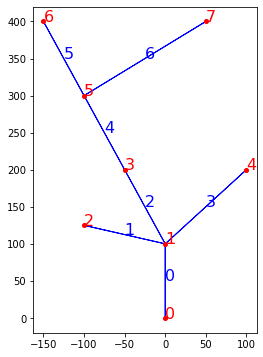

In [3]:
fig, axs = plt.subplots(1, 1, figsize=(4, 6))
graph.plot_links(nmg, with_id=True)
graph.plot_nodes(nmg, with_id=True)

### 3. Define necessary link and node fields and run a flow director on the grid to add a slope field

In [4]:
nmg.at_link["channel_width"] = np.array([9, 4.5, 7.5, 6, 7.5, 4.5, 6])  # m
nmg.at_link["reach_length"] = np.array(
    [100.0, 103.1, 111.8, 141.4, 111.8, 111.8, 180.3]
)  # m
nmg.at_node["topographic__elevation"] = np.array(
    [0.1, 0.6, 1.0, 1.1, 1.0, 1.6, 2.0, 2.0]
)
nmg.at_link["drainage_area"] = np.array([1, 0.1, 0.625, 0.15, 0.4, 0.075, 0.2])  # km^2
nmg.at_link["flow_depth"] = np.array([2, 1.2, 1.6, 1.3, 1.4, 1.2, 1.3])  # m

# instantiate and run flow director
flow_director = FlowDirectorSteepest(nmg, "topographic__elevation")
flow_director.run_one_step()

# assign bedrock elevations that are below the topographic elev for all but the "headwater" nodes
n_upstream = np.sum(flow_director.flow_link_incoming_at_node() == 1, axis=1)

nmg.at_node["bedrock__elevation"] = nmg.at_node["topographic__elevation"].copy()
nmg.at_node["bedrock__elevation"][n_upstream > 0] -= 0.1

### 4. Create an initial set of parcels on the grid. 
Note, we start with a small number of initial parcels so that parcels from later pulses of material are visible in plots of the parcels and network

In [5]:
initialize_parcels = BedParcelInitializerArea(
    nmg,
    drainage_area_coefficient=0.05,
    drainage_area_exponent=-0.2,
    sed_thickness=1,
    median_number_of_starting_parcels=2,
)
parcels = initialize_parcels()

c:\users\pfeiffa\documents\github\landlab\landlab\components\network_sediment_transporter\bed_parcel_initializers.py:592: UserWarning: BedParcelInitializer: At least one link has only [2 2 2 3 3 2 4] parcels.
  warnings.warn(msg)


See the warning? Because the NST is designed to model alluvial channel processes, it's problematic to have so few parcels. For the purpose of this tutorial, it makes for simpler visualizations.

View the initial parcels on the network model grid, shaded by grain diameter

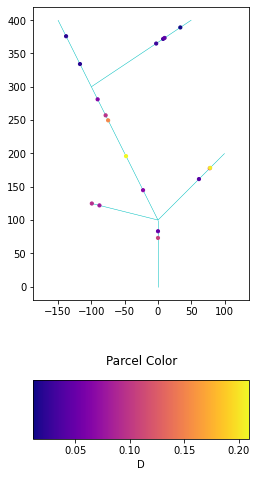

In [6]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=0,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

### 5. Instantiate and run the NetworkSedimentTransporter component using a flow event with flow depth equal to the link field "flow_depth" that last 24 hours 

In [7]:
nst = NetworkSedimentTransporter(
    nmg,
    parcels,
    flow_director,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
    active_layer_method="Constant10cm",
)

In [8]:
nst.run_one_step(dt=3600 * 24)
sed_thickness_at_nodes = (
    nmg.at_node["topographic__elevation"] - nmg.at_node["bedrock__elevation"]
)

View parcel locations after the flow event

array([ 0.27211835,  0.06172919,  0.        ,  0.11770292,  0.        ,
        0.08145077,  0.        ,  0.        ])

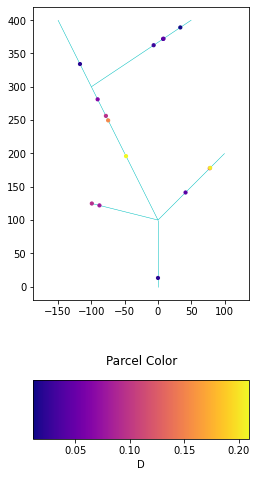

In [9]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=1,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)
sed_thickness_at_nodes = (
    nmg.at_node["topographic__elevation"] - nmg.at_node["bedrock__elevation"]
)
sed_thickness_at_nodes

### 6. Instantiate SedimentPulserAtLink
SedimentPulserAtLinks is instantiated with a network model grid and time_to_pulse function that defines the condition when a pulse is permitted. Optionally, a parcel DataRecord can be provided and default parcel attributes can be defined. 
If a parcel DataRecord is not provided, SedimentPulserAtLinks will create a new parcel DataRecord.

In [10]:
def always_time_to_pulse(time):
    """A pulse is permitted (True) for all times"""
    return True


make_pulse = SedimentPulserAtLinks(
    nmg, parcels=parcels, time_to_pulse=always_time_to_pulse
)

### 7. Make the first pulse by specifying the time of the pulse, the link(s) the pulse enters the channel network and the number of parcels sent to each link. 
Here we send a pulse to links 0 and 5 (see first figure for link id's)
Note, all inputs, except time, are lists. 
Also note that any parcel attributes not specified use default values. Default values can be set when SedimentPulserAtLinks is instantiated.

In [11]:
time = nst.time  # time of first pulse
links = [0, 5]  # link
n_parcels_at_link = [10, 30]  # parcels set to link
parcels = make_pulse(time=time, links=links, n_parcels_at_link=n_parcels_at_link)

view the location of the new parcels from the pulse

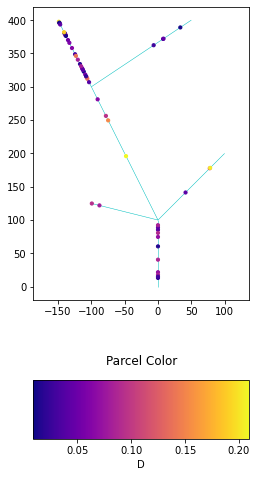

In [12]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=1,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

now apply another 24 hr flow event

In [13]:
nst.run_one_step(dt=3600 * 24)

View parcel locations after the flow event

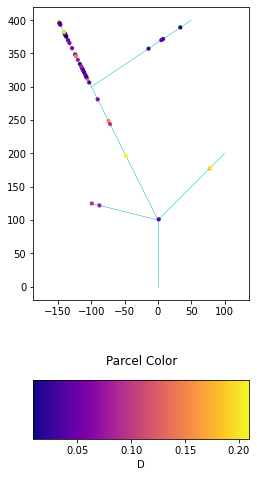

In [14]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=2,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

Notice that after the flow event, the pulse of parcels in link 0 left the channel network. Flow depth in link 0 is much higher than the lower order channels such as links 1, 3, 5 and 6.

### 8. Send a second pulse. This time we'll specify more attributes of the pulse.
We're sending boulders to link 6

In [15]:
time = nst.time  # time
links = [3, 4, 6]  # link
D50 = [0.05, 0.03, 0.5]  # median grain size
n_parcels_at_link = [3, 20, 15]  # parcels sent to link
parcel_volume = [1, 0.5, 2]  # parcel volume

parcels = make_pulse(
    time=time,
    links=links,
    D50=D50,
    n_parcels_at_link=n_parcels_at_link,
    parcel_volume=parcel_volume,
)

view the new parcels

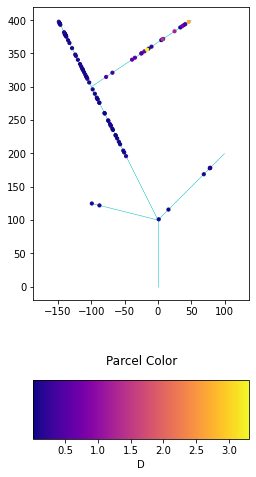

In [16]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=2,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

apply another day long flow event

In [17]:
nst.run_one_step(dt=3600 * 24)

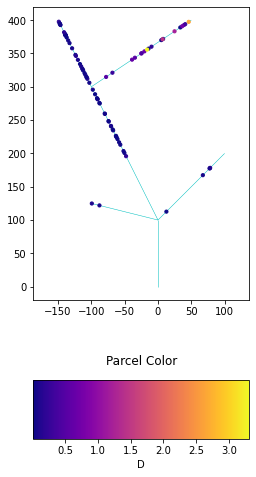

In [18]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=3,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

note that the boulders did not budge

### 9. Apply one final pulse, this time we'll change the time_to_pulse function

In [19]:
def time_to_pulse_window(time):
    """a pulse is permitted only if the time is between Ptime_min and Ptime_max"""
    Ptime_min = 340000  # seconds
    Ptime_max = 648000
    return time >= Ptime_min and time < Ptime_max


make_pulse._time_to_pulse = time_to_pulse_window

call the instance, this time defining a single pulse of 1000 parcels at link 2

In [20]:
time = nst.time  # time of first pulse
links = [2]  # link
D50 = [0.01]
n_parcels_at_link = [1000]  # parcels set to link
parcel_volume = [1]  # m^3
parcels = make_pulse(
    time=time,
    links=links,
    D50=D50,
    parcel_volume=parcel_volume,
    n_parcels_at_link=n_parcels_at_link,
)

user provided time not a time-to-pulse, parcels have not changed


note that it was not a time to pulse, nothing was added to the channel network
apply another day-long flow event

In [21]:
nst.run_one_step(dt=3600 * 24)

### 10. Try pulsing again, note that after the last flow event, time is now within the window described by the time_to_pulse_window function
this time, we send 30 parcels of fine sediment to link 1

In [22]:
time = nst.time  # time of first pulse
links = [1]  # link
D50 = [0.001]
parcel_volume = [1]  # m^3
n_parcels_at_link = [30]  # parcels set to link
parcels = make_pulse(
    time=time,
    links=links,
    D50=D50,
    parcel_volume=parcel_volume,
    n_parcels_at_link=n_parcels_at_link,
)

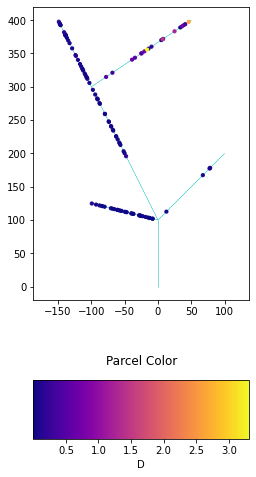

In [23]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=4,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

apply one more flow event, this one 5 days long

In [24]:
nst.run_one_step(dt=3600 * 24 * 5)
sed_thickness_at_nodes = (
    nmg.at_node["topographic__elevation"] - nmg.at_node["bedrock__elevation"]
)
sed_thickness_at_nodes

array([ 0.49143811,  0.        ,  0.        ,  0.        ,  0.        ,
        0.08145077,  0.        ,  0.        ])

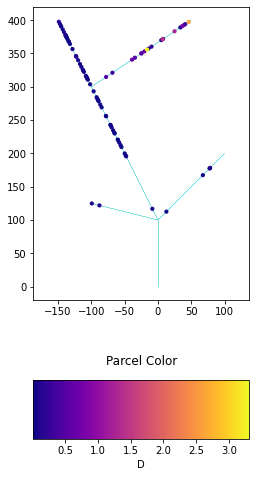

In [25]:
fig = plot_network_and_parcels(
    nmg,
    parcels,
    parcel_time_index=5,  # index of time, not the time value
    parcel_color_attribute="D",
    parcel_size=10,
    parcel_alpha=1.0,
    figsize=(3, 6),
)

Note that after the flow event, the fines in link 2 have been flushed out of the network

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>